In [1]:
%matplotlib inline


import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams

import seaborn as sns

sns.set_style("white")
sns.set_context("paper", rc={"lines.linewidth": 1})

rcParams['axes.titlepad'] = 20
rcParams['axes.titlesize'] = "medium"
rcParams['axes.edgecolor'] = "red"
rcParams['axes.spines.right'] = rcParams['axes.spines.top'] = False
rcParams['xtick.labelsize'] = "small"
rcParams['xtick.major.pad'] = 10

rcParams['ytick.labelsize'] = "small"
rcParams['ytick.major.pad'] = 10
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.labelpad'] = 10

In [2]:
root_path = "/home/fat-fighter/Documents/cs771-project/hybrid-method/"

## Description of Files

### Folder: features

- **tracks-mfcc.csv** - Contains already extracted mfcc features from all tracks using 30-60 seconds of tracks
- **tracks-cluster-probabilities.csv** - Contains the cluster probabolities and assignments for all tracks (based on their mfcc features_
- **timbres-cluster-probabilities.csv** - Contains the cluster probabilities and assignments for all segment timbres of all tracks
- **tracks-collective-timbres-clusters-features.csv** - Contains the extracted features of a track using its timbres' collective cluster probabilities

### Folder: million-song-subset

- **tracks-features.csv** - Contains mfcc features extracted from tracks in the MSS
- **tracks-timbres.csv** - Contains segment timbres for all tracks

### Folder: taste-profile-subset

- **songs.txt** - A list of song ids
- **users.txt** - A list of user ids
- **train-triplets.txt** - A user-song-count triplets
- **song-to-tracks.txt** - A song-track id mapping

## Finding Optimal Number of Track Clusters (Based on Tracks' MFCC Features)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
local_path = root_path + "data/"

n_jobs = -1
max_iter = 500
algorithm = "full"
n_init = 5

In [ ]:
tracks_data = pd.read_csv(local_path + "features/tracks-mfcc.csv", sep="\t")

cols = tracks_data.columns.tolist()[1:]
tracks_features = tracks_data[cols]

In [ ]:
estimators = [
    (n_clusters, KMeans(n_clusters=n_clusters, random_state=0, n_jobs=n_jobs, max_iter=max_iter, algorithm=algorithm, n_init=n_init))
    for n_clusters in range(5, 16, 1)
]

In [ ]:
for n_clusters, estimator in estimators:
    estimator.fit(tracks_features)

In [ ]:
with open(local_path + "features/tracks-clustering-kmeans-inertias.csv", "w") as f:
    cluster_inertias = []
    
    for n_clusters, estimator in estimators:
        cluster_inertias.append([n_clusters, estimator.inertia_])
        
    f.write("\n".join([str(n_clusters) + "\t" + str(inertia) for n_cluster, inertia in cluster_inertias]))
    
    cluster_inertias = np.array(cluster_inertias)

### Inertial Plot

In [ ]:
sns.pointplot(cluster_inertias[:, 0], cluster_inertias[:, 1])

plt.title("Tracks Clustering: Inertia for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Variance")

plt.savefig(local_path + "plots/tracks-clustering-kmeans-inertia.png", dpi=250)
plt.show()

### PCA Plot of Tracks MFCC (for 10 Clusters)

In [ ]:
decomposed_tracks_features = PCA(n_components=2).fit(tracks_features).transform(tracks_features)

In [ ]:
n_clusters, estimator = estimators[5]
cluster_assignments = estimator.labels_

In [ ]:
for i in range(n_clusters):
    plt.scatter(decomposed_tracks_features[cluster_assignments == i, 0], decomposed_tracks_features[cluster_assignments == i, 1], alpha=.8, rasterized=True, s=0.7)
    
plt.title("Tracks MFCC: PCA Plot")
    
plt.savefig(local_path + "plots/tracks-mfcc-pca.png", dpi=250)
plt.show()

## Clustering Tracks using GMM

In [ ]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
local_path = root_path + "data/"

n_clusters = 10
max_iter = 5000
covariance_type = "diag"
n_init = 3

In [ ]:
tracks_data = pd.read_csv(local_path + "/features/tracks-mfcc.csv", sep="\t")

cols = tracks_data.columns[1:]
tracks_mfcc = tracks_data[cols]

In [ ]:
estimator = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, max_iter=max_iter, random_state=0, n_init=n_init)

In [ ]:
estimator.fit(tracks_mfcc)

In [ ]:
probs = estimator.predict_proba(tracks_mfcc)
cluster_assignments = estimator.predict(tracks_mfcc)

In [ ]:
outfile = local_path + "/features/tracks-cluster-probabilities.csv"

In [ ]:
with open(outfile, "w") as f:
    for i, song_id in enumerate(tracks_data["id"]):
        params = [song_id] + list(probs[i]) + [cluster_assignments[i]]

        params = [str(param) for param in params]

        f.write("\t".join(params) + "\n")

### LDA Plot of Tracks MFCC

In [ ]:
decomposed_tracks_mfcc = LinearDiscriminantAnalysis(n_components=2).fit(tracks_mfcc, cluster_assignments).transform(tracks_mfcc)

In [ ]:
for i in range(n_clusters):
    plt.scatter(decomposed_tracks_mfcc[cluster_assignments == i, 0], decomposed_tracks_mfcc[cluster_assignments == i, 1], alpha=.8, rasterized=True, s=0.7)
    
plt.title("Tracks MFCC: LDA Plot (After GMM)")
    
plt.savefig(local_path + "plots/tracks-mfcc-gmm-clustering-pca.png", dpi=250)
plt.show()

## Mapping Users to Tracks

In [ ]:
local_path = root_path + "data/taste-profile-subset/"

In [ ]:
songs_to_tracks = dict()
count = 0
with open(local_path + "songs-to-tracks.txt", "r") as f:
    for line in f.readlines():
        line = line.strip(" \t\n\r").split()
        if len(line) > 1:
            songs_to_tracks[line[0]] = line[1:]

In [ ]:
outfile = open(local_path + "user-track-counts.txt", "w")

In [ ]:
with open(local_path + "user-song-counts.txt", "r") as f:
    line = f.readline()
    while line:
        line = line.strip(" \t\n\r").split()
        if len(line) == 3 and line[1] in songs_to_tracks:
            for track in songs_to_tracks[line[1]]:
                outfile.write("\t".join([line[0], track, line[2]]) + "\n")
        line = f.readline()

In [ ]:
outfile.close()

## Computing User Features (Based on Tracks' Cluster Probabilities)

In [ ]:
import numpy as np

In [ ]:
local_path = root_path + "data/"

n_clusters = 10

In [ ]:
tracks_mfcc = dict()
with open(local_path + "features/tracks-cluster-probabilities.csv", "r") as f:
    line = f.readline()
    while line:
        line = f.readline()
        line = line.strip(" \t\n\r").split()
        if len(line) == 12:
            tracks_mfcc[line[0]] = np.array([float(field) for field in line[1:-1]])

In [ ]:
user_features = dict()
user_track_counts = dict()

In [ ]:
with open(local_path + "taste-profile-subset/user-track-counts.txt", "r") as f:
    line = f.readline()
    while line:
        line = line.strip(" \t\n\r").split()
        if len(line) == 3 and line[1] in tracks_mfcc:
            if line[0] not in user_track_counts:
                user_features[line[0]] = np.zeros(n_clusters)
                user_track_counts[line[0]] = 0
                
            user_features[line[0]] += tracks_mfcc[line[1]]
            user_track_counts[line[0]] += 1
        line = f.readline()

In [ ]:
outfile = local_path + "features/user-features.csv"

In [ ]:
with open(outfile, "w") as f:
    for user in user_features:
        f.write("\t".join([user] + [str(field) for field in (user_features[user] / float(user_track_counts[user]))]) + "\n")

## Finding Optimal Number of Users Clusters (Based on Users' Computed Features)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
local_path = root_path + "data/"

n_jobs = -1
max_iter = 500
algorithm = "full"
n_init = 5

In [ ]:
user_data = pd.read_csv(local_path + "features/user-features.csv", sep="\t", header=None)

cols = user_data.columns.tolist()[1:]
user_features = user_data[cols]

In [ ]:
estimators = [
    (n_clusters, KMeans(n_clusters=n_clusters, random_state=0, n_jobs=n_jobs, max_iter=max_iter, algorithm=algorithm, n_init=n_init))
    for n_clusters in range(10, 30, 1)
]

In [ ]:
for n_clusters, estimator in estimators:
    estimator.fit(user_features)

In [ ]:
with open(local_path + "features/users-clustering-kmeans-inertias.csv", "w") as f:
    cluster_inertias = []
    
    for n_clusters, estimator in estimators:
        cluster_inertias.append([n_clusters, estimator.inertia_])
        
    f.write("\n".join([str(n_clusters) + "\t" + str(inertia) for n_cluster, inertia in cluster_inertias]))
    
    cluster_inertias = np.array(cluster_inertias)

### Inertial Plot

In [ ]:
sns.pointplot(cluster_inertias[:, 0].astype(int), cluster_inertias[:, 1])

plt.title("Tracks Clustering: Inertia for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Variance")

plt.savefig(local_path + "plots/tracks-clustering-kmeans-inertia.png", dpi=250)
plt.show()

### PCA Plot of Tracks MFCC (for 10 Clusters)

In [ ]:
decomposed_user_features = PCA(n_components=2).fit(user_features).transform(user_features)

In [ ]:
n_clusters, estimator = estimators[10]
cluster_assignments = estimator.labels_

In [ ]:
for i in range(n_clusters):
    plt.scatter(decomposed_user_features[cluster_assignments == i, 0], decomposed_user_features[cluster_assignments == i, 1], alpha=.8, rasterized=True, s=0.7)
    
plt.title("User Features: PCA Plot")
    
plt.savefig(local_path + "plots/user-features-pca.png", dpi=250)
plt.show()

## Clustering Users using GMM

In [3]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
local_path = root_path + "data/"

n_clusters = 20
max_iter = 5000
covariance_type = "diag"
n_init = 3

In [5]:
user_data = pd.read_csv(local_path + "/features/user-features.csv", sep="\t", header=None)

cols = user_data.columns[1:]
user_features = user_data[cols]

In [6]:
estimator = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, max_iter=max_iter, random_state=0, n_init=n_init)

In [7]:
estimator.fit(user_features)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=5000,
        means_init=None, n_components=20, n_init=3, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [9]:
probs = estimator.predict_proba(user_features)
cluster_assignments = estimator.predict(user_features)

In [10]:
outfile = local_path + "/features/user-cluster-probabilities.csv"

In [13]:
with open(outfile, "w") as f:
    for i, user_id in enumerate(user_data[user_data.columns[0]]):
        params = [user_id] + list(probs[i]) + [cluster_assignments[i]]

        params = [str(param) for param in params]

        f.write("\t".join(params) + "\n")

### LDA Plot of User Features

In [14]:
decomposed_user_features = LinearDiscriminantAnalysis(n_components=2).fit(user_features, cluster_assignments).transform(user_features)

/home/fat-fighter/Softwares/conda/envs/cs771-project-env/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


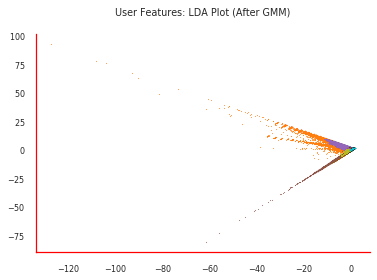

In [15]:
for i in range(n_clusters):
    plt.scatter(decomposed_user_features[cluster_assignments == i, 0], decomposed_user_features[cluster_assignments == i, 1], alpha=.8, rasterized=True, s=0.7)
    
plt.title("User Features: LDA Plot (After GMM)")
    
plt.savefig(local_path + "plots/user-features-gmm-clustering-pca.png", dpi=250)
plt.show()